#Facial landmarks with facemesh

Facemesh has a powerful trained mediapipe model to find facial landmarks.

First, we need to install mediapipe to use it.

In [38]:
!pip install mediapipe

In [39]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

**After the installation, we need to import it. I will import numpy for matricial manipulation and opencv for image manipulation as well.**


In [40]:
import cv2 # for image manipulation
import mediapipe as mp
import numpy as np

**Lets take an web image to detect its landmarks:**

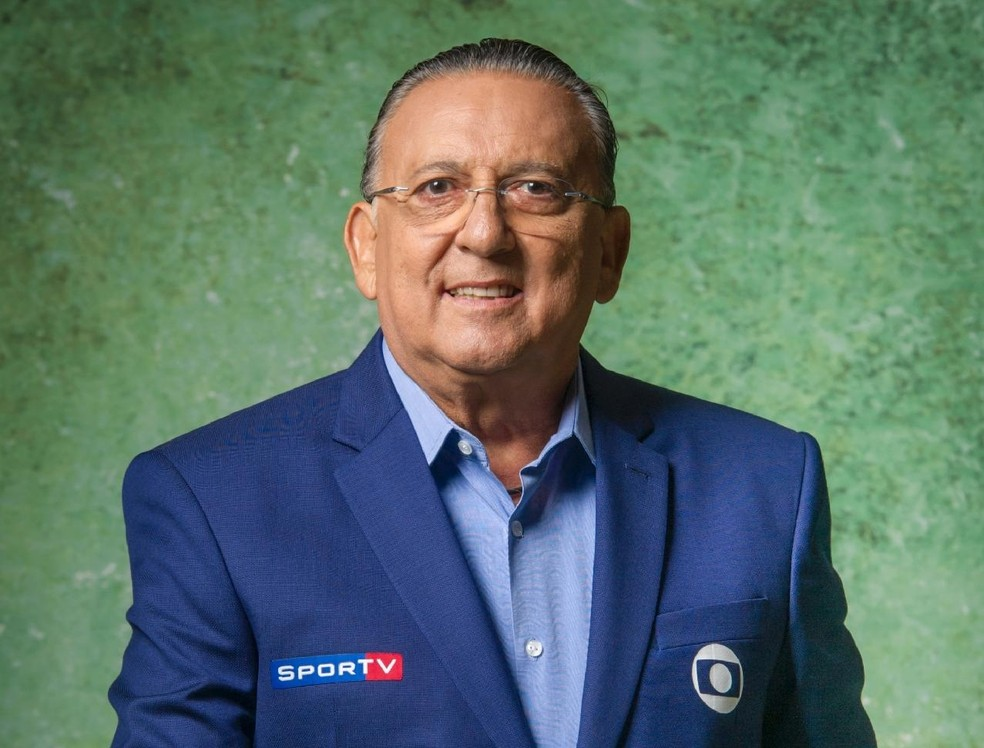

In [41]:
from skimage import io # to import images from url
from google.colab.patches import cv2_imshow #to be able to show images in colab

urls = ['https://static.wikia.nocookie.net/vvikipedia/images/e/e8/Galvaobueno.jpg/revision/latest?cb=20210411213234&path-prefix=pt']
for url in urls:
  image = io.imread(url)
  cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))


**You also can try your own image by using the code below.**

In [ ]:
from google.colab import files

def process_input(filename):
  image = io.imread(filename)
  cv2_imshow(cv2.cvtColor(io.imread(url), cv2.COLOR_RGB2BGR))

# upload files
uploaded = files.upload()
for filename in uploaded.keys():
  print('Processing:', filename)
  image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
  cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

**Let's use facemesh to find its facial landmarks.**

In [42]:
#Imports
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# Transform image to input format
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)

# Detect face landmarks from the input image.
detection_result = detector.detect(mp_image)

**Facemesh returns 478 facial landmarks**

Each facial landmark index can be found in https://i.stack.imgur.com/T1ypF.jpg

Let's find the pupils landmarks:

In [43]:
print('left_pupil_landmarks:', detection_result.face_landmarks[0][468])
print('right_pupil_landmarks:', detection_result.face_landmarks[0][473])

left_pupil_landmarks: NormalizedLandmark(x=0.44623857736587524, y=0.24781858921051025, z=0.008545547723770142, visibility=0.0, presence=0.0)
right_pupil_landmarks: NormalizedLandmark(x=0.5455162525177002, y=0.24910591542720795, z=0.013144372031092644, visibility=0.0, presence=0.0)


**An easy way to manipulate the facial landmarks is converting then to numpy array format**

The function below convert the detections to numpy array format

In [44]:
def landmarks_2np(detection_result):
    total = len(detection_result.face_landmarks[0])
    landmarks = np.zeros([total,3])
    for j in range(total):
      landmarks[j,0] += detection_result.face_landmarks[0][j].x
      landmarks[j,1] += detection_result.face_landmarks[0][j].y
      landmarks[j,2] += detection_result.face_landmarks[0][j].z

    return landmarks

In [45]:
landmarks = landmarks_2np(detection_result)

#printing the landmarks of left and right pupil to check
print(landmarks[468,:])
print(landmarks[473,:])

[0.44623858 0.24781859 0.00854555]
[0.54551625 0.24910592 0.01314437]


**We can print the mesh only, or print it in the image**


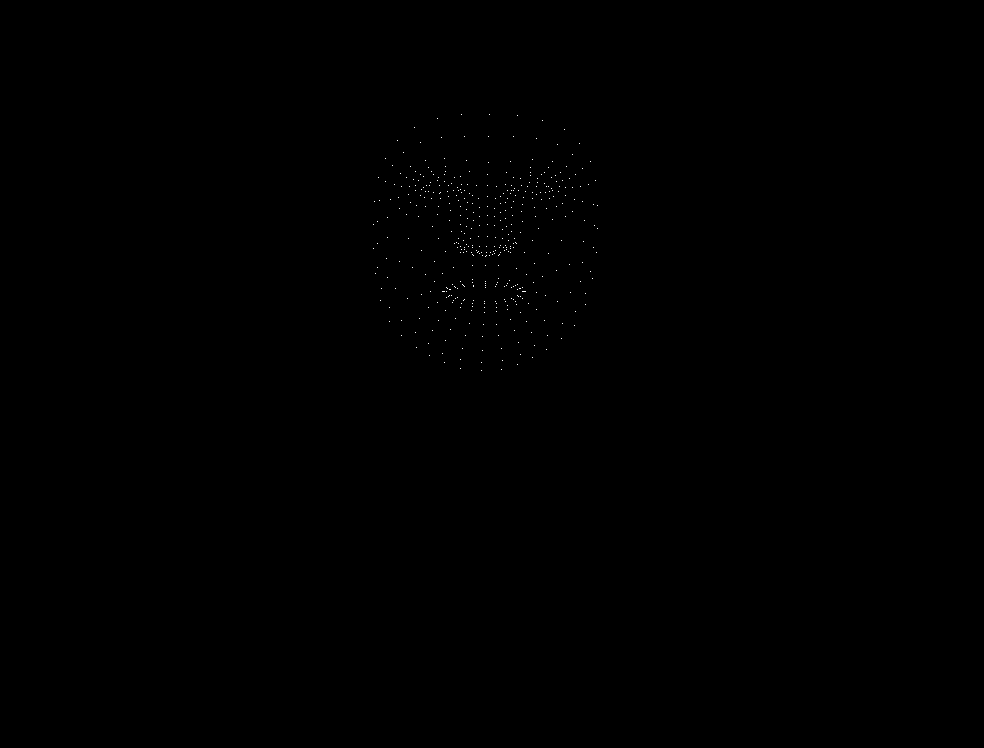

In [46]:
from copy import deepcopy

image_height, image_width, _ = image.shape

blank_image = np.zeros((image_height,image_width,3), np.uint8)

for i in landmarks:
  # The landmarks are normalized, to plot then we need to multiply by the proper image dimension
  blank_image = cv2.circle(blank_image, (int(i[0]*image_width),int(i[1]*image_height)), radius=0, color=(255, 255, 255), thickness=1)
cv2_imshow(blank_image)

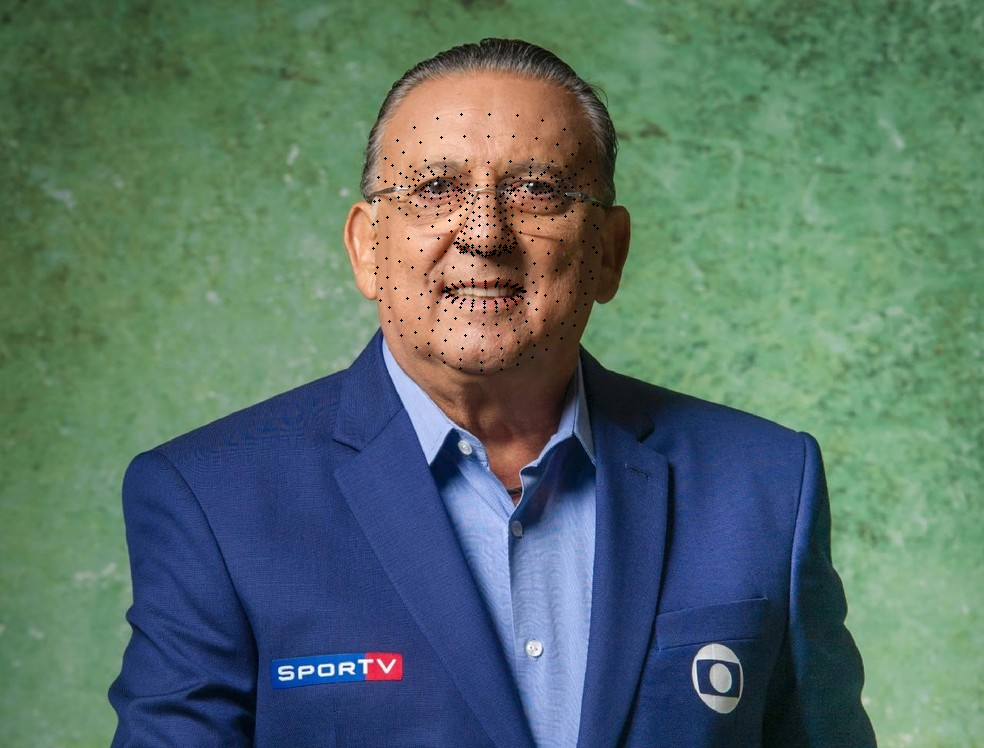

In [47]:
image_disp = deepcopy(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
for i in landmarks:
  # The landmarks are normalized, to plot then we need to multiply by the proper image dimension
  image_disp = cv2.circle(image_disp, (int(i[0]*image_width),int(i[1]*image_height)), radius=0, color=(0, 0, 0), thickness=2)
cv2_imshow(image_disp)

**We can reshape the landmarks to any dimension we want**

Let's half the dimension of the facial landmarks

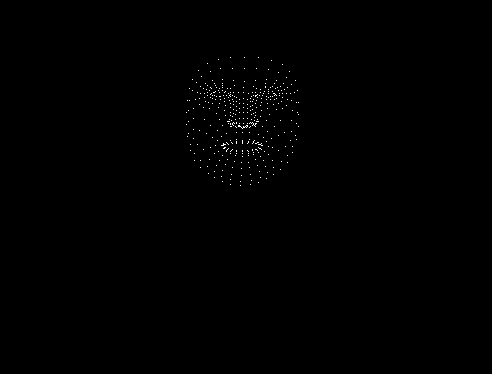

In [48]:
image_height, image_width, _ = image.shape
image_height, image_width = int(image_height/2), int(image_width/2)

blank_image = np.zeros((image_height,image_width,3), np.uint8)

for i in landmarks:
  # The landmarks are normalized, to plot then we need to multiply by the proper image dimension
  blank_image = cv2.circle(blank_image, (int(i[0]*image_width),int(i[1]*image_height)), radius=0, color=(255, 255, 255), thickness=1)
cv2_imshow(blank_image)

**The mesh is 3D**

Therefore, we can rotate or translate it as needed.

In [49]:
import math

def getCenterMass(mesh):
    return mesh.mean(0)

def Rz(a):
    Rz = np.array([[math.cos(a), -math.sin(a), 0],
                  [math.sin(a),  math.cos(a), 0],
                  [     0     ,      0      , 1]])
    return Rz

def Ry(a):
    Ry = np.array([[math.cos(a),  0, math.sin(a)],
                  [    0      ,  1,      0     ],
                  [-math.sin(a), 0, math.cos(a)]])
    return Ry

def Rx(a):
    Rx = np.array([[1,    0       ,      0      ],
                  [0, math.cos(a), -math.sin(a)],
                  [0, math.sin(a),  math.cos(a)]])
    return Rx

def image_rotation3D(rlandmarks, z, y, x):
    #Rotation Matrix
    R = np.matmul(Rz(z),Ry(y))
    R = np.matmul(R,Rx(x))

    # Translation matrix to shift the image center to the origin
    cm = getCenterMass(rlandmarks)

    for i in range(len(rlandmarks[:,0])):
        rlandmarks[i,:] = (np.matmul(R, rlandmarks[i,:]-cm))+cm

    return rlandmarks

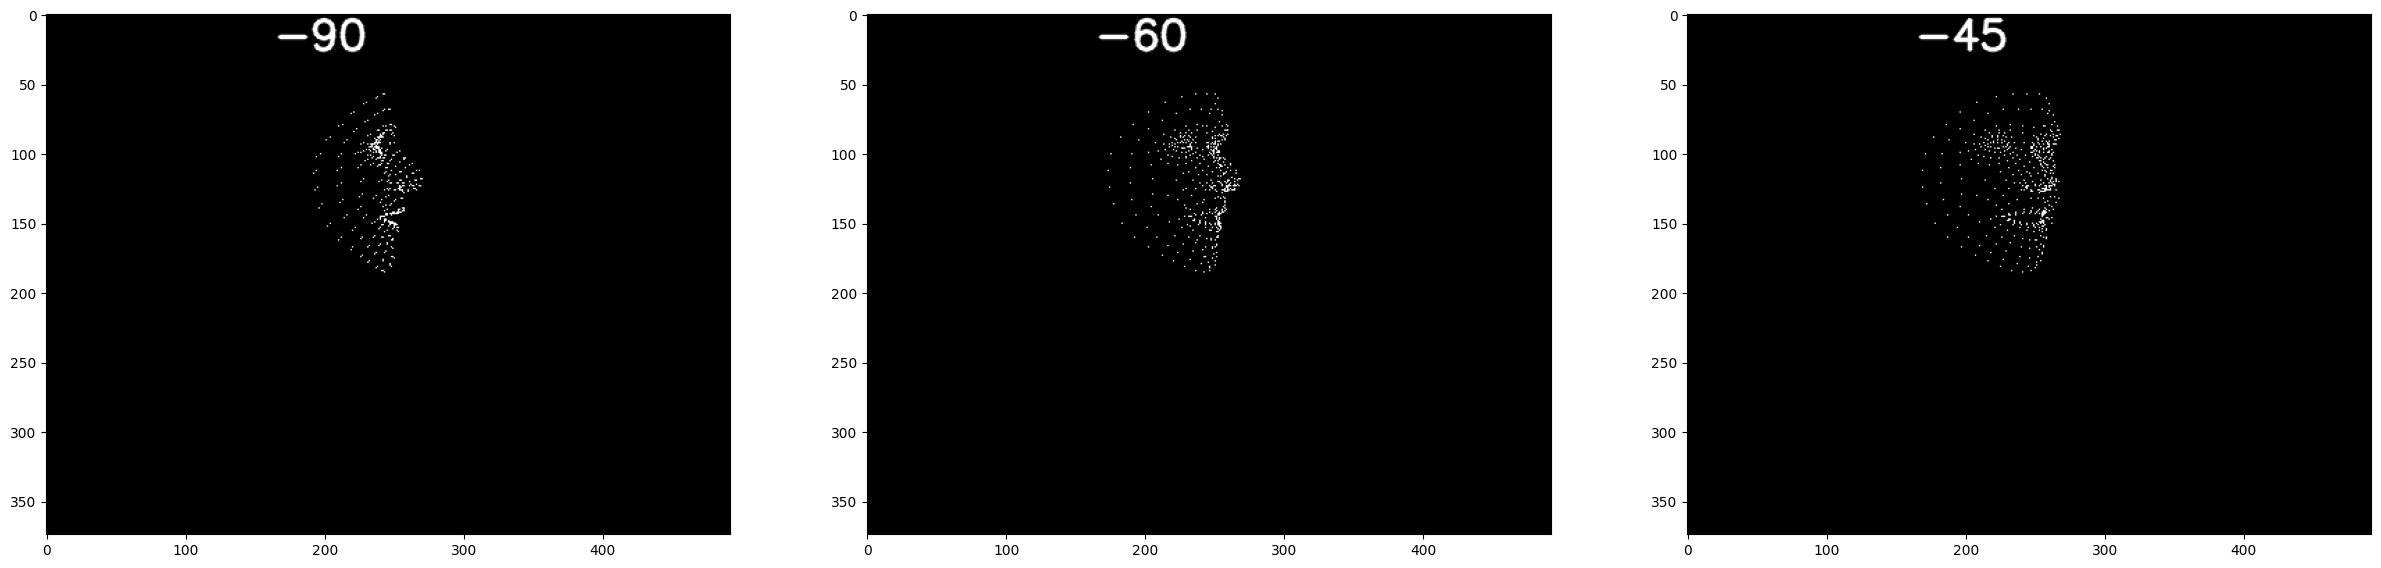

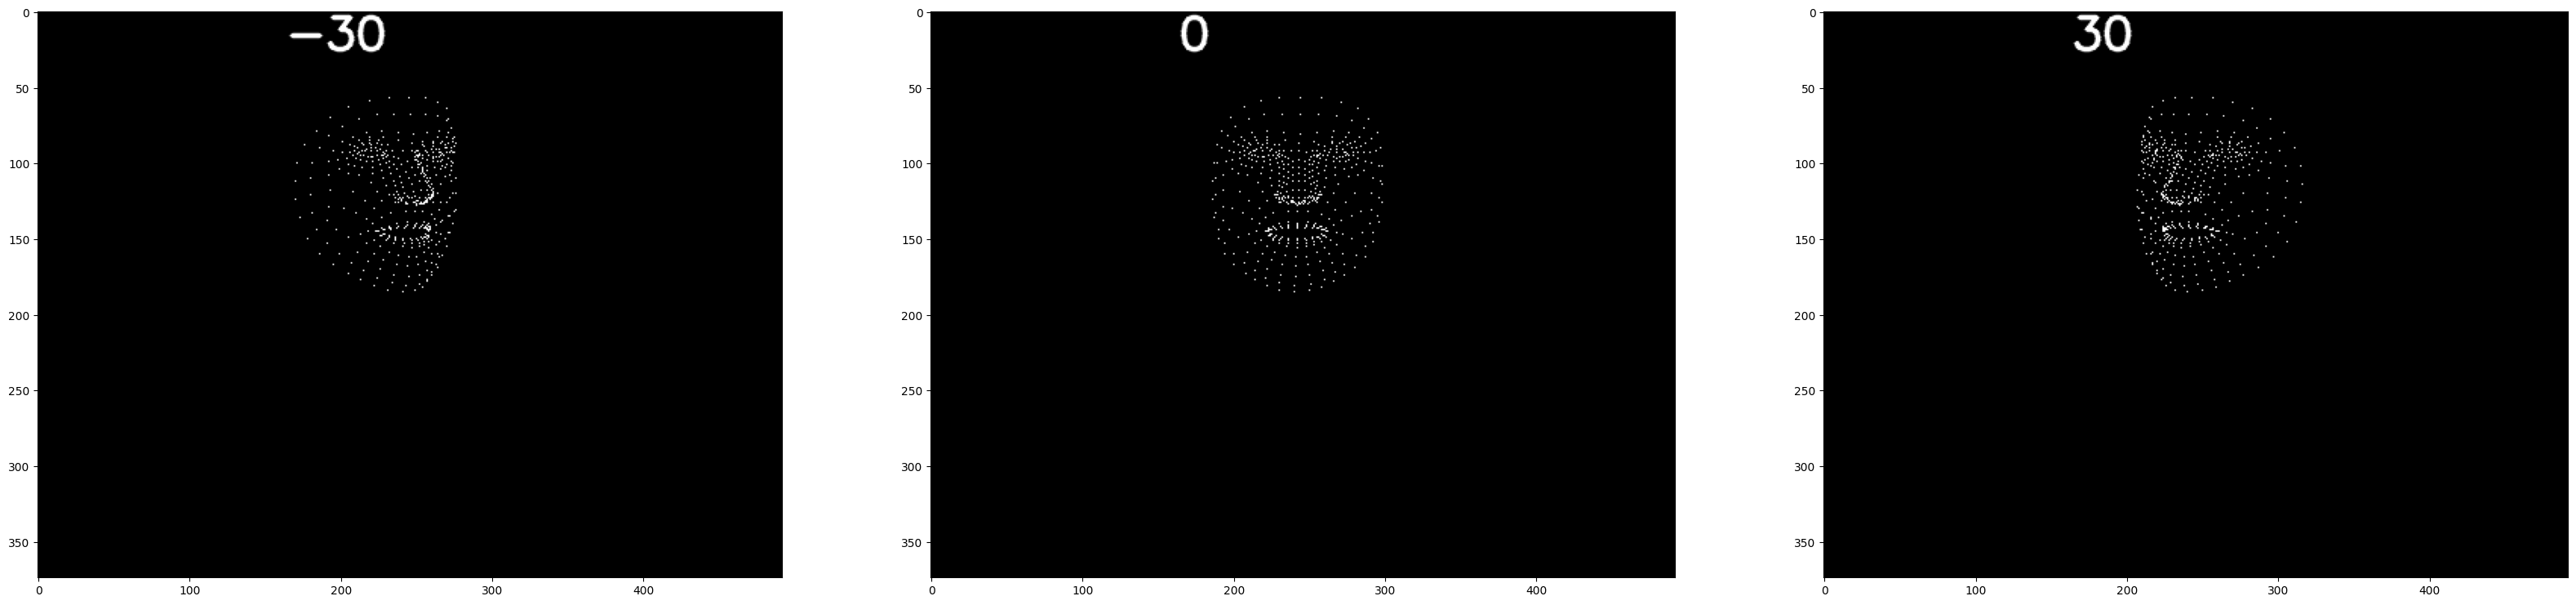

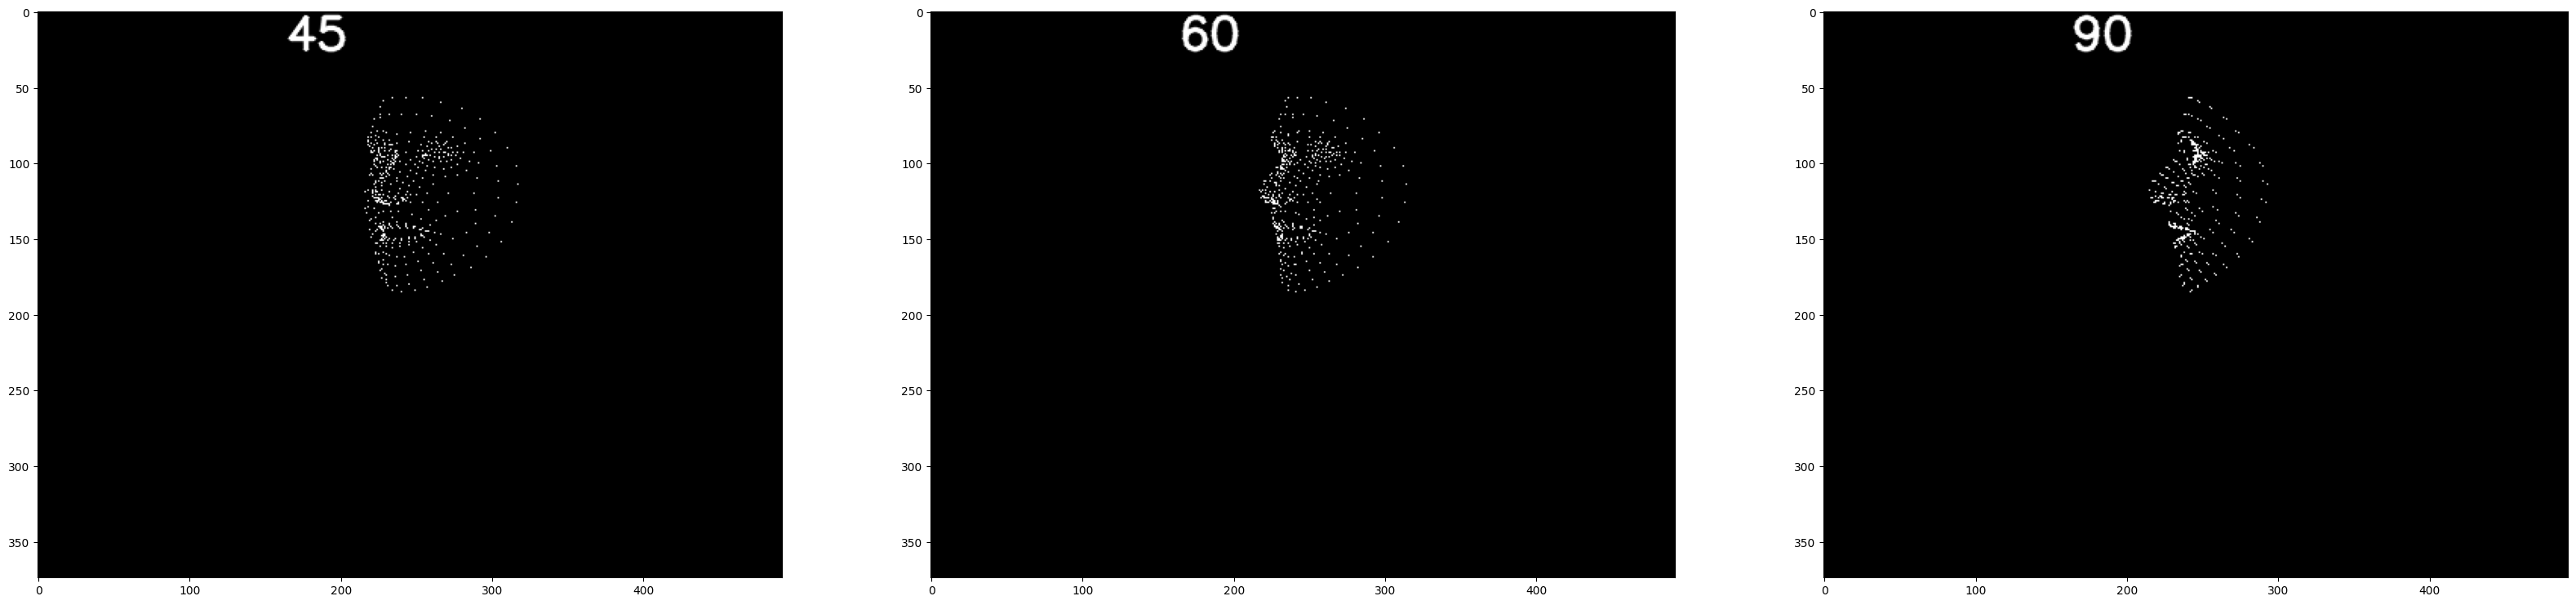

In [50]:
import matplotlib.pyplot as plt


image_height, image_width, _ = image.shape
image_height, image_width = int(image_height/2), int(image_width/2)

img_count = 0
f, axarr = plt.subplots(1,3)
f.set_size_inches(30, 30)

for j in [-90, -60, -45, -30, 0, 30, 45, 60, 90]:
  landmarks_copy = deepcopy(landmarks)
  image_rotation3D(landmarks_copy, 0, (j)*np.pi/180, 0)

  blank_image = np.zeros((image_height,image_width,3), np.uint8)

  for i in landmarks_copy:
    blank_image = cv2.circle(blank_image, (int(i[0]*image_width),int(i[1]*image_height)), radius=0, color=(255, 255, 255), thickness=1)

  blank_image = cv2.putText(blank_image, str(j), (int(image_width/3), 25), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (255, 255, 255), 2, cv2.LINE_AA)
  #cv2_imshow(blank_image)

  if img_count >= 3:
      plt.show()
      img_count = 0
      f, axarr = plt.subplots(1,3)
      f.set_size_inches(40, 40)

  blank_image = cv2.cvtColor(blank_image, cv2.COLOR_RGB2BGR)
  axarr[img_count].imshow(blank_image)
  img_count += 1

